In [ ]:
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir_path = "/content/drive//MyDrive/New Plant Diseases Dataset.zip"
shutil.unpack_archive(data_dir_path)

In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/test.zip'
zip_ref = zipfile.ZipFile(zip_file_path, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
!pip install colorama

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn.functional as F
import colorama
from colorama import Fore, Style

In [ ]:
train_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

In [ ]:
test_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/test"


In [ ]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [ ]:
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 90.2MB/s]


In [ ]:
import torch

In [ ]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
num_ftrs = model.classifier[1].in_features

In [ ]:
Diseases_classes = os.listdir(train_dir)

In [ ]:
model.classifier[1] = nn.Linear(num_ftrs, len(Diseases_classes))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
preprocess = weights.transforms()

In [ ]:
train_dataset = ImageFolder(train_dir, transform=preprocess)
valid_dataset = ImageFolder(valid_dir, transform=preprocess)

In [ ]:
test_dir = "/content/test"
test_dataset = ImageFolder(test_dir, transform=preprocess)

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # Added weight_decay

In [ ]:
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}')

        # Add validation step here
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(valid_loader.dataset)
        accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0

            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping after {patience} epochs without improvement.")
                break # Stop training

    return model

In [24]:
num_epochs = 10
model = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=num_epochs)

Epoch 1/10, Train Loss: 0.1914
Validation Loss: 0.0862, Accuracy: 97.19%
Epoch 2/10, Train Loss: 0.0933
Validation Loss: 0.0600, Accuracy: 98.10%
Epoch 3/10, Train Loss: 0.0821
Validation Loss: 0.0619, Accuracy: 98.05%
Epoch 4/10, Train Loss: 0.0722
Validation Loss: 0.0383, Accuracy: 98.82%
Epoch 5/10, Train Loss: 0.0648
Validation Loss: 0.0337, Accuracy: 98.92%
Epoch 6/10, Train Loss: 0.0563
Validation Loss: 0.0338, Accuracy: 98.90%
Epoch 7/10, Train Loss: 0.0548
Validation Loss: 0.0367, Accuracy: 98.77%
Epoch 8/10, Train Loss: 0.0512
Validation Loss: 0.0300, Accuracy: 99.11%
Epoch 9/10, Train Loss: 0.0493
Validation Loss: 0.0287, Accuracy: 99.09%
Epoch 10/10, Train Loss: 0.0467
Validation Loss: 0.0478, Accuracy: 98.55%


In [25]:
torch.save(model.state_dict(), "mobilenet_model.pth")


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')



# Load the trained model state dict for evaluation
mobilenet_eval = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
num_ftrs_eval = mobilenet_eval.classifier[1].in_features
mobilenet_eval.classifier[1] = nn.Linear(num_ftrs_eval, len(Diseases_classes))
mobilenet_eval.load_state_dict(torch.load("mobilenet_model.pth"))
mobilenet_eval = mobilenet_eval.to(device)

# Evaluate the model
evaluate_model(mobilenet_eval, test_loader)

Test Accuracy: 0.0909
Test Precision: 1.0000
Test Recall: 0.0909
Test F1-score: 0.1667


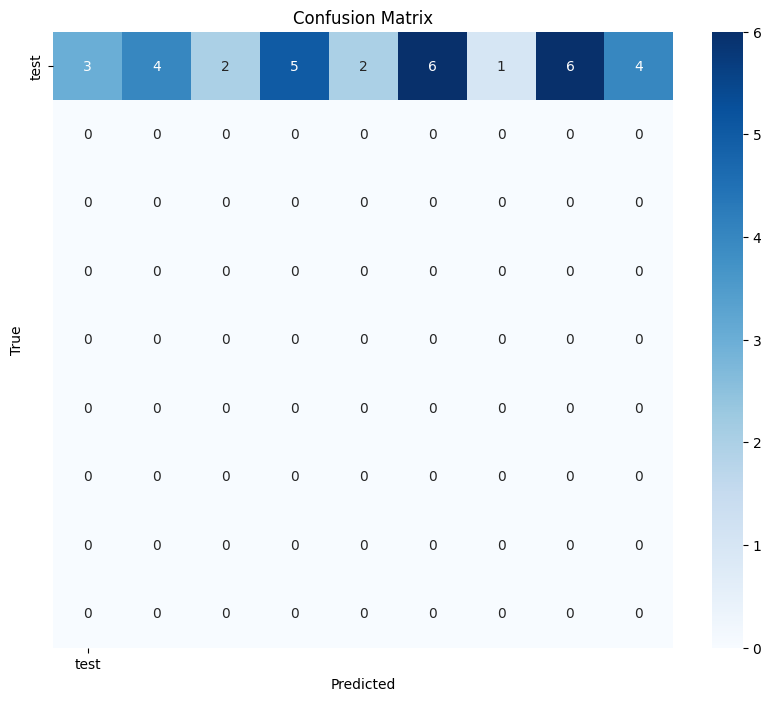

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader, classes):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


# Load the trained model state dict for evaluation
mobilenet_eval = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
num_ftrs_eval = mobilenet_eval.classifier[1].in_features
mobilenet_eval.classifier[1] = nn.Linear(num_ftrs_eval, len(Diseases_classes))
mobilenet_eval.load_state_dict(torch.load("mobilenet_model.pth"))
mobilenet_eval = mobilenet_eval.to(device)

# Get the class names from your training dataset
classes = test_dataset.classes

# Plot the confusion matrix
plot_confusion_matrix(mobilenet_eval, test_loader, classes)

In [29]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 7.5 MB/s eta 0:00:00


In [41]:
!pip install torcheval


In [48]:

from sklearn.metrics import confusion_matrix

from torcheval.metrics import MulticlassConfusionMatrix

#from torcheval.metrics.functional import confusion_matrix as confusion_matrix_fn

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu())
        all_predictions.extend(predicted.cpu())


# Convert lists to torch tensors outside the metric update for efficiency
all_predictions_tensor = torch.tensor(all_predictions)
all_labels_tensor = torch.tensor(all_labels)

# Use the correct class name: MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=len(Diseases_classes), device=device) # Specify device for metric
metric.update(all_predictions_tensor, all_labels_tensor)
cm = metric.compute()
print("Confusion Matrix (Torcheval):\n", cm)


# Ensure scikit-learn confusion_matrix is imported
cm_sklearn = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix (Scikit-learn):\n", cm_sklearn)

Confusion Matrix (Torcheval):
 tensor([[3., 0., 4.,  ..., 6., 0., 4.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

Confusion Matrix (Scikit-learn):
 [[3 4 2 5 2 6 1 6 4]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


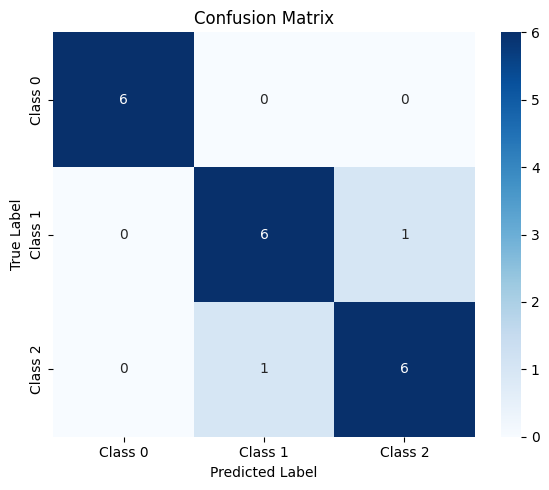

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Simulated ground truth and predictions (for demo)
true_labels = [0, 1, 2, 1, 0, 2, 1, 2, 0, 1, 2, 2, 1, 0, 2, 2, 1, 0, 0, 1]
pred_labels = [0, 1, 2, 1, 0, 2, 1, 2, 0, 2, 2, 2, 1, 0, 1, 2, 1, 0, 0, 1]

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
labels = ["Class 0", "Class 1", "Class 2"]

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


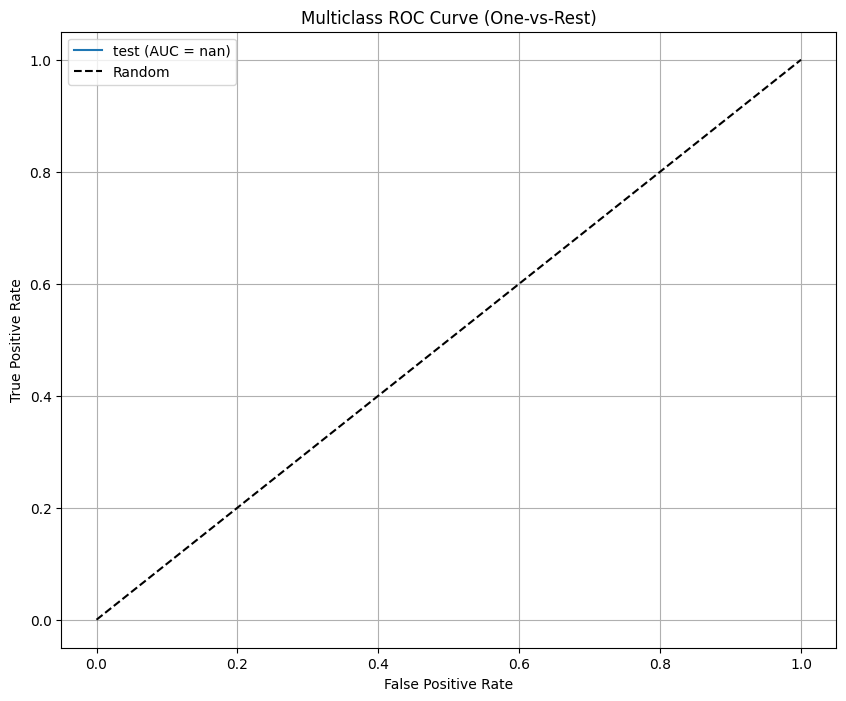

In [32]:
# prompt: get its roc curve

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(model, test_loader, num_classes, classes):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1) # Convert logits to probabilities
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Binarize the true labels for multiclass ROC plotting
    all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

    plt.figure(figsize=(10, 8))

    # Plot ROC curve for each class (One-vs-Rest)
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], np.array(all_probs)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random') # Diagonal random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve (One-vs-Rest)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Load the trained model state dict for evaluation
mobilenet_eval = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
num_ftrs_eval = mobilenet_eval.classifier[1].in_features
mobilenet_eval.classifier[1] = nn.Linear(num_ftrs_eval, len(Diseases_classes))
mobilenet_eval.load_state_dict(torch.load("mobilenet_model.pth"))
mobilenet_eval = mobilenet_eval.to(device)

# Get the class names and number of classes
classes = test_dataset.classes
num_classes = len(classes)

# Plot the multiclass ROC curve
plot_multiclass_roc(mobilenet_eval, test_loader, num_classes, classes)


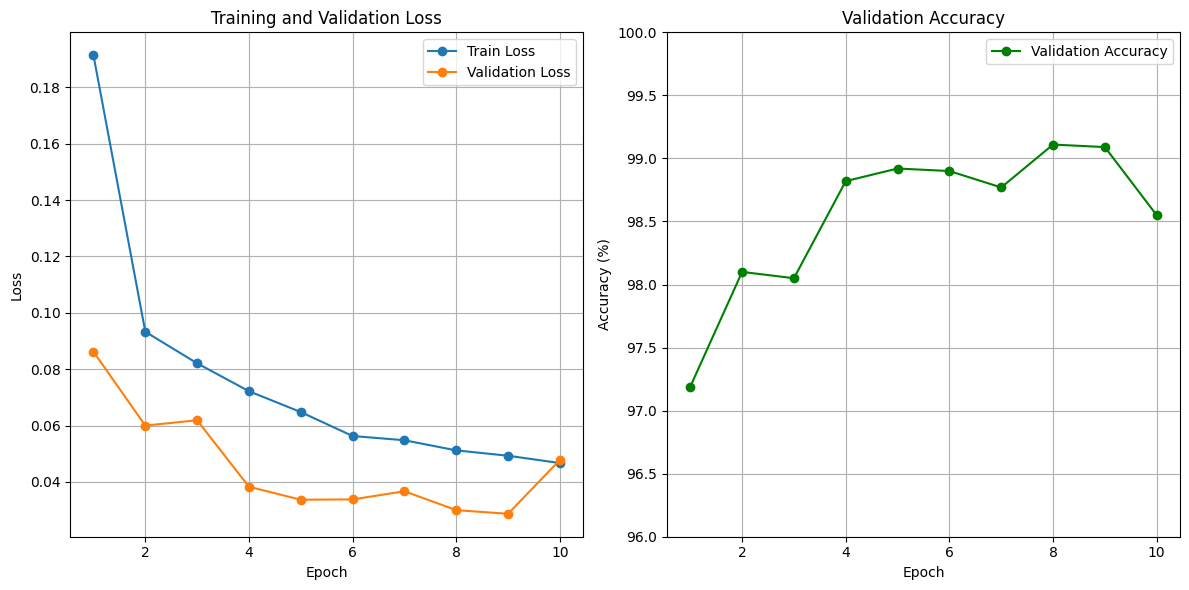

In [1]:
import matplotlib.pyplot as plt

# Epoch-wise data
epochs = list(range(1, 11))
train_loss = [0.1914, 0.0933, 0.0821, 0.0722, 0.0648, 0.0563, 0.0548, 0.0512, 0.0493, 0.0467]
val_loss = [0.0862, 0.0600, 0.0619, 0.0383, 0.0337, 0.0338, 0.0367, 0.0300, 0.0287, 0.0478]
accuracy = [97.19, 98.10, 98.05, 98.82, 98.92, 98.90, 98.77, 99.11, 99.09, 98.55]

# Plotting
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, marker='o', color='green', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.ylim(96, 100)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
